In [2]:
%matplotlib inline
import numpy as np

>**作者**：Emmanuelle Gouillart, Gaël Varoquaux  
>原文: http://www.scipy-lectures.org/advanced/image_processing/index.html

这个部分解决用核心的科学模块NumPy和SciPy做基本的图像操作和处理。这个教程中涵盖的一些操作可能对于一些其他类型的多维度数据处理比对图像处理更加有用。特别是，子摸块[scipy.ndimage](http://docs.scipy.org/doc/scipy/reference/ndimage.html#module-scipy.ndimage)提供了在N维Numpy数组上操作的方法。

---
**也看一下: ** 对于更高级的图像处理和图像特有的程序，见专注于[skimage](http://scikit-image.org/docs/stable/api/skimage.html#module-skimage)模块教程[Scikit-image: 图像处理](3.6. scikit-learn：Python中的机器学习.ipynb)。

---

---
**图像 = 2-D 数值数组**

(或者 3-D: CT, MRI, 2D + time; 4-D, ...)

这里, **图像 == Numpy 数组** `np.array`

---

**本教程中使用的工具:**

- `numpy`: 基础的数组操作
- `scipy`: `scipy.ndimage` 专注于图像处理的子模块 (n维 图像)。见[文档](http://docs.scipy.org/doc/scipy/reference/tutorial/ndimage.html):

In [3]:
from scipy import ndimage

**图像处理中的常见任务:**

- 输入/输出、显示图像
- 基础操作: 剪切, 翻转、旋转...
- 图像过滤: 降噪, 锐化
- 图形分割: 根据不同的对象标记像素
- 分类
- 特征提取
- 配准
- ...

**章节内容**
    
    打开和写入图像文件
    显示图像
    基础操作
        统计信息
        几何图像变换
    图像过滤
        模糊/光滑
        锐化
        降噪
        数学形态学
    特征提取
        边缘检测
        分隔
    测量对象属性: ndimage.measurements

## 2.6.1 打开和写入图像文件

将数组写入文件:

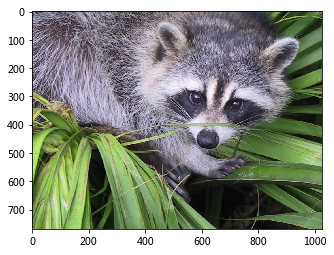

In [4]:
from scipy import misc
f = misc.face()
misc.imsave('face.png', f) # 使用图像模块 (PIL)

import matplotlib.pyplot as plt
plt.imshow(f)
plt.show()

从图像文件创建一个numpy数组:

In [5]:
from scipy import misc
face = misc.face()
misc.imsave('face.png', face) # 首先我们需要创建这个PNG文件

face = misc.imread('face.png')
type(face)      

numpy.ndarray

In [6]:
face.shape, face.dtype

((768, 1024, 3), dtype('uint8'))

对于8位的图像 (0-255) dtype是uint8

打开raw文件 (照相机, 3-D 图像)

In [7]:
face.tofile('face.raw') # 创建raw文件
face_from_raw = np.fromfile('face.raw', dtype=np.uint8)
face_from_raw.shape

(2359296,)

In [8]:
face_from_raw.shape = (768, 1024, 3)

需要知道图像的shape和dtype (如何去分离数据类型)。

对于大数据, 使用`np.memmap`来做内存映射:

In [9]:
face_memmap = np.memmap('face.raw', dtype=np.uint8, shape=(768, 1024, 3))

(数据从文件中读取，并没有加载到内存)

处理一组图像文件

In [10]:
for i in range(10):
    im = np.random.random_integers(0, 255, 10000).reshape((100, 100))
    misc.imsave('random_%02d.png' % i, im)
from glob import glob
filelist = glob('random*.png')
filelist.sort()

/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 255 + 1) instead
  


## 2.6.2 显示图像

使用`matplotlib`和`imshow`在`matplotlib图形内部`显示图像:

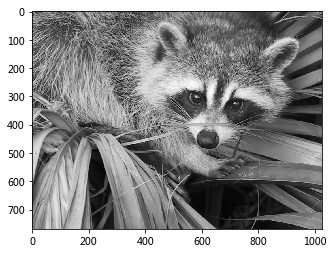

In [11]:
f = misc.face(gray=True)  # 取回灰度图像
import matplotlib.pyplot as plt
plt.imshow(f, cmap=plt.cm.gray) 

通过设置最小和最大值增加对比度:

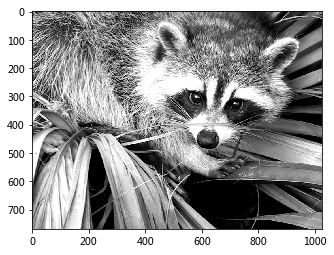

In [12]:
plt.imshow(f, cmap=plt.cm.gray, vmin=30, vmax=200)

(-0.5, 1023.5, 767.5, -0.5)

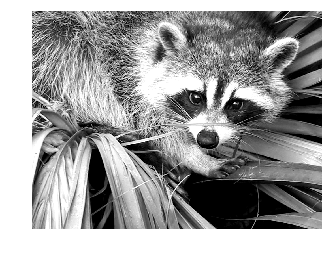

In [13]:
plt.imshow(f, cmap=plt.cm.gray, vmin=30, vmax=200)
# 删除座标轴和刻度
plt.axis('off')

画出轮廓线:

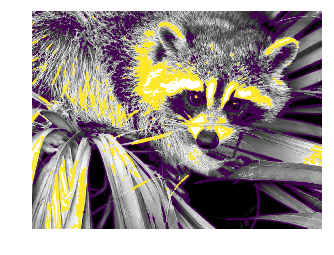

In [14]:
plt.imshow(f, cmap=plt.cm.gray, vmin=30, vmax=200)
# 删除座标轴和刻度
plt.axis('off')
plt.contour(f, [50, 200])

[[Python 源代码]](http://www.scipy-lectures.org/advanced/image_processing/auto_examples/plot_display_face.html#example-plot-display-face-py)

对于要精确检查的密度变量，使用`interpolation='nearest'`:

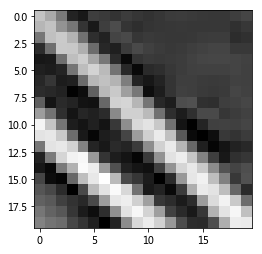

In [15]:
plt.imshow(f[320:340, 510:530], cmap=plt.cm.gray)        

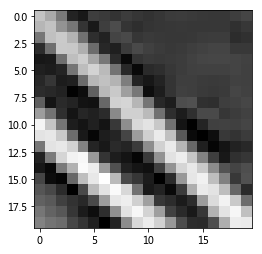

In [16]:
plt.imshow(f[320:340, 510:530], cmap=plt.cm.gray, interpolation='nearest')        

[[Python 源代码]](http://www.scipy-lectures.org/advanced/image_processing/auto_examples/plot_interpolation_face.html#example-plot-interpolation-face-py)

**也可以看一下** 3-D 可视化: Mayavi

见[使用Mayavi的3D绘图](http://www.scipy-lectures.org/packages/3d_plotting/index.html#mayavi-label)。

- Image plane widgets
- Isosurfaces
- ...

![](http://www.scipy-lectures.org/_images/decorations.png)

## 2.6.3 基础操作

图像是数组: 使用完整的numpy机制。

![](http://www.scipy-lectures.org/_images/axis_convention.png)

In [17]:
face = misc.face(gray=True)
face[0, 40]

127

In [18]:
# 切片
face[10:13, 20:23]

array([[141, 153, 145],
       [133, 134, 125],
       [ 96,  92,  94]], dtype=uint8)

In [19]:
face[100:120] = 255
lx, ly = face.shape
X, Y = np.ogrid[0:lx, 0:ly]
mask = (X - lx / 2) ** 2 + (Y - ly / 2) ** 2 > lx * ly / 4
# 掩码（masks）
face[mask] = 0
# 象征索引（Fancy indexing）
face[range(400), range(400)] = 255

![](http://www.scipy-lectures.org/_images/sphx_glr_plot_numpy_array_001.png)

[[Python source code]](http://www.scipy-lectures.org/advanced/image_processing/auto_examples/plot_numpy_array.html#example-plot-numpy-array-py)

### 2.6.3.1 统计信息

In [20]:
face = misc.face(gray=True)
face.mean()

113.48026784261067

In [21]:
face.max(), face.min()

(250, 0)

`np.histogram`

---
**练习**

- 将`scikit-image` logo作为数组打开 (http://scikit-image.org/_static/img/logo.png), 或者在你电脑上的其他图像。
- 剪切图像的有意义部分，例如，logo中的python圆形。
- 用`matplotlib`显示图像数组。改变interpolation方法并且放大看一下差异。
- 将你的图像改变为灰度
- 通过改变它的最小最大值增加图像的对比度。**选做：**使用`scipy.stats.scoreatpercentile` (读一下文本字符串!) 来饱和最黑5%的像素和最亮5%的像素。
- 将数组保存为两个不同的文件格式 (png, jpg, tiff)

![](http://www.scipy-lectures.org/_images/scikit_image_logo.png)

---

### 2.6.3.2 几何图像变换

In [22]:
face = misc.face(gray=True)
lx, ly = face.shape
# 剪切
crop_face = face[lx / 4: - lx / 4, ly / 4: - ly / 4]
# up <-> down 翻转
flip_ud_face = np.flipud(face)
# 旋转
rotate_face = ndimage.rotate(face, 45)
rotate_face_noreshape = ndimage.rotate(face, 45, reshape=False)

TypeError: slice indices must be integers or None or have an __index__ method

![](http://www.scipy-lectures.org/_images/sphx_glr_plot_geom_face_001.png)

[[Python source code]](http://www.scipy-lectures.org/advanced/image_processing/auto_examples/plot_geom_face.html#example-plot-geom-face-py)

## 2.6.4 图像过滤

**局部过滤器**: 通过临近像素值的函数来替换像素的值。

**邻居**: 方块 (选择大小)、 硬盘、或者更复杂的结构化元素。

![](http://www.scipy-lectures.org/_images/kernels.png)

### 2.6.4.1 模糊 / 光滑

**高斯过滤器** 来自 `scipy.ndimage`:

In [23]:
from scipy import misc
face = misc.face(gray=True)
blurred_face = ndimage.gaussian_filter(face, sigma=3)
very_blurred = ndimage.gaussian_filter(face, sigma=5)

**均匀过滤器**

In [24]:
local_mean = ndimage.uniform_filter(face, size=11)

![](http://www.scipy-lectures.org/_images/sphx_glr_plot_blur_001.png)

[[Python source code]](http://www.scipy-lectures.org/advanced/image_processing/auto_examples/plot_blur.html)

### 2.6.4.2 锐化

锐化模糊的图像:

In [25]:
from scipy import misc
face = misc.face(gray=True).astype(float)
blurred_f = ndimage.gaussian_filter(face, 3)

通过添加Laplacian的近似值来增加边缘的权重:

In [26]:
filter_blurred_f = ndimage.gaussian_filter(blurred_f, 1)
alpha = 30
sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)

![](http://www.scipy-lectures.org/_images/sphx_glr_plot_sharpen_001.png)

[[Python source code]](http://www.scipy-lectures.org/advanced/image_processing/auto_examples/plot_sharpen.html#example-plot-sharpen-py)

### 2.6.4.3 降噪

有噪音的脸:

In [27]:
from scipy import misc
f = misc.face(gray=True)
f = f[230:290, 220:320]
noisy = f + 0.4 * f.std() * np.random.random(f.shape)

**高斯过滤器**光滑了噪音... 以及边缘:

In [28]:
gauss_denoised = ndimage.gaussian_filter(noisy, 2)

绝大多数局部线性各向同性过滤器模糊图像 (`ndimage.uniform_filter`)

**中位数过滤器**更好的保留的边缘:

In [29]:
med_denoised = ndimage.median_filter(noisy, 3)

![](http://www.scipy-lectures.org/_images/sphx_glr_plot_face_denoise_001.png)

[[Python source code]](http://www.scipy-lectures.org/advanced/image_processing/auto_examples/plot_face_denoise.html#example-plot-face-denoise-py)

中位数过滤器: 对直边缘的结果更好 (低曲度):

In [30]:
im = np.zeros((20, 20))
im[5:-5, 5:-5] = 1
im = ndimage.distance_transform_bf(im)
im_noise = im + 0.2 * np.random.randn(*im.shape)
im_med = ndimage.median_filter(im_noise, 3)

![](http://www.scipy-lectures.org/_images/sphx_glr_plot_denoising_001.png)

[[Python source code]](http://www.scipy-lectures.org/advanced/image_processing/auto_examples/plot_denoising.html)

其他排名过滤器：`ndimage.maximum_filter`、`ndimage.percentile_filter`

其他的局部非线性过滤器: Wiener (`scipy.signal.wiener`) 等等.

**非局部过滤器**

---

**练习: 降噪**

- 创建一个带有一些对象 (圆形、椭圆、正方形或随机形状) 的二元图像 (0 和 1) .
- 添加一些噪音 (例如, 20% 的噪音)
- 用两种不同的降噪方法来降噪这个图像: 高斯过滤器和中位数过滤器。
- 比较两种不同降噪方法的直方图。哪一个与原始图像（无噪音）的直方图最接近?

---

---

**也看一下：** 在`skimage.denoising`中有更多的的降噪过滤器可用，见教程[Scikit-image: 图像处理](http://www.scipy-lectures.org/packages/scikit-image/index.html#scikit-image).

---

### 2.6.4.4 数学形态学

看一下[wikipedia](https://en.wikipedia.org/wiki/Mathematical_morphology)上的数学形态学定义。

探索一个简单形状 (结构化的元素) 的图像，然后根据这个形状是如何局部适应或不适应这个图像来修改这个图像。

**结构化元素:**

In [31]:
el = ndimage.generate_binary_structure(2, 1)
el

array([[False,  True, False],
       [ True,  True,  True],
       [False,  True, False]], dtype=bool)

In [32]:
el.astype(np.int)

array([[0, 1, 0],
       [1, 1, 1],
       [0, 1, 0]])

![](http://www.scipy-lectures.org/_images/diamond_kernel.png)

**风化(Erosion)** = 最小值过滤器。用结构化元素所覆盖的最小值来替换像素的值。:

In [33]:
a = np.zeros((7,7), dtype=np.int)
a[1:6, 2:5] = 1
a

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

In [34]:
ndimage.binary_erosion(a).astype(a.dtype)

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

In [35]:
#风化删除了比结构小的对象
ndimage.binary_erosion(a, structure=np.ones((5,5))).astype(a.dtype)

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

![](http://www.scipy-lectures.org/_images/morpho_mat.png)

**扩大(Dilation)**：最大值过滤器：

In [36]:
a = np.zeros((5, 5))
a[2, 2] = 1
a

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [37]:
ndimage.binary_dilation(a).astype(a.dtype)

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  1.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

对于灰度值图像同样适用:

In [38]:
np.random.seed(2)
im = np.zeros((64, 64))
x, y = (63*np.random.random((2, 8))).astype(np.int)
im[x, y] = np.arange(8)
bigger_points = ndimage.grey_dilation(im, size=(5, 5), structure=np.ones((5, 5)))
square = np.zeros((16, 16))
square[4:-4, 4:-4] = 1
dist = ndimage.distance_transform_bf(square)
dilate_dist = ndimage.grey_dilation(dist, size=(3, 3), structure=np.ones((3, 3)))

![](http://www.scipy-lectures.org/_images/plot_greyscale_dilation_1.png)

[[Python source code]](http://www.scipy-lectures.org/advanced/image_processing/auto_examples/plot_greyscale_dilation.html)

**Opening**: erosion + dilation:

In [39]:
a = np.zeros((5,5), dtype=np.int)
a[1:4, 1:4] = 1; a[4, 4] = 1
a

array([[0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 0, 1]])

In [40]:
# Opening 删除小对象
ndimage.binary_opening(a, structure=np.ones((3,3))).astype(np.int)

array([[0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0]])

In [41]:
# Opening 也可以光滑转角
ndimage.binary_opening(a).astype(np.int)

array([[0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0]])

**应用**: 去除噪音:

In [42]:
square = np.zeros((32, 32))
square[10:-10, 10:-10] = 1
np.random.seed(2)
x, y = (32*np.random.random((2, 20))).astype(np.int)
square[x, y] = 1
open_square = ndimage.binary_opening(square)
eroded_square = ndimage.binary_erosion(square)
reconstruction = ndimage.binary_propagation(eroded_square, mask=square)

![](http://www.scipy-lectures.org/_images/plot_propagation_1.png)

[[Python source code]](http://www.scipy-lectures.org/advanced/image_processing/auto_examples/plot_propagation.html)

**Closing**: dilation + erosion
许多其他的数学形态学操作: hit 和 miss 转换、tophat等等。

### 2.6.5.2 分割

- 直方图分割 (没有空间信息)

In [43]:
n = 10
l = 256
im = np.zeros((l, l))
np.random.seed(1)
points = l*np.random.random((2, n**2))
im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
im = ndimage.gaussian_filter(im, sigma=l/(4.*n))
mask = (im > im.mean()).astype(np.float)
mask += 0.1 * im
img = mask + 0.2*np.random.randn(*mask.shape)
hist, bin_edges = np.histogram(img, bins=60)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
binary_img = img > 0.5

![](http://www.scipy-lectures.org/_images/plot_histo_segmentation_1.png)
[[Python source code]](http://www.scipy-lectures.org/advanced/image_processing/auto_examples/plot_histo_segmentation.html)

用数学形态学来清理结果:

In [44]:
# 删除小白色区域
open_img = ndimage.binary_opening(binary_img)
# 删除小黑洞
close_img = ndimage.binary_closing(open_img)

![](http://www.scipy-lectures.org/_images/plot_clean_morpho_1.png)
[[Python source code]](http://www.scipy-lectures.org/advanced/image_processing/auto_examples/plot_clean_morpho.html)

---

**练习**

检查重建操作 (erosion + propagation) 生成一个比opening/closing更好的结果:

In [45]:
eroded_img = ndimage.binary_erosion(binary_img)
reconstruct_img = ndimage.binary_propagation(eroded_img, mask=binary_img)
tmp = np.logical_not(reconstruct_img)
eroded_tmp = ndimage.binary_erosion(tmp)
reconstruct_final = np.logical_not(ndimage.binary_propagation(eroded_tmp, mask=tmp))
np.abs(mask - close_img).mean()

0.0072783654884356133

In [46]:
np.abs(mask - reconstruct_final).mean() 

0.00059502552803868841

---

---

**练习**

检查第一步降噪 (例如，中位数过滤器) 如何影响直方图，检查产生的基于直方图的分割是否更加准确。

---

---
**也可以看一下**：更高级分割算法可以在`scikit-image`中找到: 见[Scikit-image: 图像处理](http://www.scipy-lectures.org/packages/scikit-image/index.html#scikit-image)。

---

---

**也可以看一下**：其他科学计算包为图像处理提供的算法。在这个例子中，我们使用`scikit-learn`中的谱聚类函数以便分割黏在一起的对象。

In [47]:
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)
radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0])**2 + (y - center1[1])**2 < radius1**2
circle2 = (x - center2[0])**2 + (y - center2[1])**2 < radius2**2
circle3 = (x - center3[0])**2 + (y - center3[1])**2 < radius3**2
circle4 = (x - center4[0])**2 + (y - center4[1])**2 < radius4**2

# 4个圆形
img = circle1 + circle2 + circle3 + circle4
mask = img.astype(bool)
img = img.astype(float)

img += 1 + 0.2*np.random.randn(*img.shape)
# 将图像转化为边缘带有坡度值的图。
graph = image.img_to_graph(img, mask=mask)

# 用一个梯度递减函数: 我们用它轻度依赖于接近voronoi的梯度细分
graph.data = np.exp(-graph.data/graph.data.std())

labels = spectral_clustering(graph, n_clusters=4, eigen_solver='arpack')
label_im = -np.ones(mask.shape)
label_im[mask] = labels

![](http://www.scipy-lectures.org/_images/image_spectral_clustering.png)

## 2.6.6 测量对象属性: `ndimage.measurements`

合成数据：

In [48]:
n = 10
l = 256
im = np.zeros((l, l))
points = l*np.random.random((2, n**2))
im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
im = ndimage.gaussian_filter(im, sigma=l/(4.*n))
mask = im > im.mean()

- 联通分支分析

标记联通分支：`ndimage.label`:

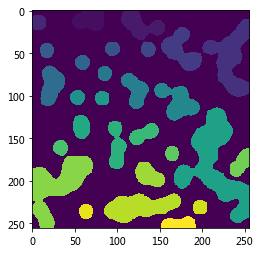

In [49]:
label_im, nb_labels = ndimage.label(mask)
nb_labels # 多少区域?

plt.imshow(label_im)  

![](http://www.scipy-lectures.org/_images/plot_synthetic_data_1.png)

[[Python source code]](http://www.scipy-lectures.org/advanced/image_processing/auto_examples/plot_synthetic_data.html#example-plot-synthetic-data-py)

计算每个区域的大小、mean_value等等:

In [50]:
sizes = ndimage.sum(mask, label_im, range(nb_labels + 1))
mean_vals = ndimage.sum(im, label_im, range(1, nb_labels + 1))

清理小的联通分支:

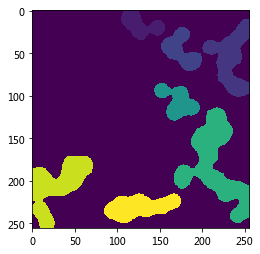

In [51]:
mask_size = sizes < 1000
remove_pixel = mask_size[label_im]
remove_pixel.shape

label_im[remove_pixel] = 0
plt.imshow(label_im)        

现在用`np.searchsorted`重新分配标签:

In [52]:
labels = np.unique(label_im)
label_im = np.searchsorted(labels, label_im)

![](http://www.scipy-lectures.org/_images/plot_measure_data_1.png)

[[Python source code]](http://www.scipy-lectures.org/advanced/image_processing/auto_examples/plot_measure_data.html)

找到包含感兴趣对象的区域:

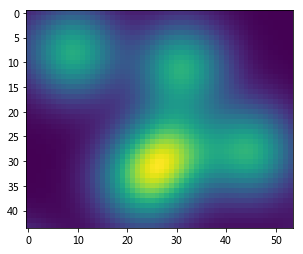

In [53]:
slice_x, slice_y = ndimage.find_objects(label_im==4)[0]
roi = im[slice_x, slice_y]
plt.imshow(roi)  

[[Python source code]](http://www.scipy-lectures.org/advanced/image_processing/auto_examples/plot_find_object.html)

其他空间测量: `ndimage.center_of_mass`, `ndimage.maximum_position`, 等等，可以在分割应用这个有限的部分之外使用。

实例: 块平均数:

In [54]:
from scipy import misc
f = misc.face(gray=True)
sx, sy = f.shape
X, Y = np.ogrid[0:sx, 0:sy]
regions = (sy//6) * (X//4) + (Y//6)  # 注意我们使用广播
block_mean = ndimage.mean(f, labels=regions, index=np.arange(1, regions.max() +1))
block_mean.shape = (sx // 4, sy // 6)

![](http://www.scipy-lectures.org/_images/plot_block_mean_1.png)

[[Python source code]](http://www.scipy-lectures.org/advanced/image_processing/auto_examples/plot_block_mean.html)

当区域是标准的块时，使用步长刻度更加高效 (实例: [使用刻度的虚假维度](http://www.scipy-lectures.org/advanced/advanced_numpy/index.html#stride-manipulation-label))。

非标准空间块: radial平均:

In [55]:
sx, sy = f.shape
X, Y = np.ogrid[0:sx, 0:sy]
r = np.hypot(X - sx/2, Y - sy/2)
rbin = (20* r/r.max()).astype(np.int)
radial_mean = ndimage.mean(f, labels=rbin, index=np.arange(1, rbin.max() +1))

![](http://www.scipy-lectures.org/_images/plot_radial_mean_1.png)

[[Python source code]](http://www.scipy-lectures.org/advanced/image_processing/auto_examples/plot_radial_mean.html)

- 其他测量

相关函数、Fourier/wavelet频谱、等㩐。

使用数学形态学的一个实例: [granulometry](https://en.wikipedia.org/wiki/Granulometry_%28morphology%29)

In [56]:
def disk_structure(n):
    struct = np.zeros((2 * n + 1, 2 * n + 1))
    x, y = np.indices((2 * n + 1, 2 * n + 1))
    mask = (x - n)**2 + (y - n)**2 <= n**2
    struct[mask] = 1
    return struct.astype(np.bool)


def granulometry(data, sizes=None):
    s = max(data.shape)
    if sizes == None:
        sizes = range(1, s/2, 2)
    granulo = [ndimage.binary_opening(data, \
        structure=disk_structure(n)).sum() for n in sizes]
    return granulo


np.random.seed(1)
n = 10
l = 256
im = np.zeros((l, l))
points = l*np.random.random((2, n**2))
im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
im = ndimage.gaussian_filter(im, sigma=l/(4.*n))

mask = im > im.mean()

granulo = granulometry(mask, sizes=np.arange(2, 19, 4))

/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  # This is added back by InteractiveShellApp.init_path()


![](http://www.scipy-lectures.org/_images/plot_granulo_1.png)

[[Python source code]](http://www.scipy-lectures.org/advanced/image_processing/auto_examples/plot_granulo.html)

---
**也看一下: **关于图像处理的更多内容:
- 关于[Scikit-image](http://www.scipy-lectures.org/packages/scikit-image/index.html#scikit-image)的章节
- 其他更有力更完整的模块: [OpenCV](https://opencv-python-tutroals.readthedocs.org/en/latest) (Python绑定), [CellProfiler](http://www.cellprofiler.org/), [ITK](http://www.itk.org/) 带有Python绑定